# 🧠 ResNet18 for Aerial Scene Classification
使用 ResNet18 深度学习模型在划分好的 split_data 目录结构下进行训练、验证和测试。
数据比例为 Train 70% / Val 10% / Test 20%。

In [2]:

import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, confusion_matrix
from tqdm import tqdm


In [5]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 打印当前使用的设备
print("Using device:", device)
if device.type == 'cuda':
    print("GPU Name:", torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.5.1
Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
True
NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:

def load_dataset_from_split(split_path):
    images, labels = [], []
    class_names = sorted(os.listdir(split_path))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(split_path, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label)
    return images, labels, class_names


In [5]:

def initialize_model(num_classes):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


In [6]:

def get_transforms(input_size=224):
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_transform, test_transform = get_transforms()

train_images, train_labels, class_names = load_dataset_from_split("../split_data/train")
val_images, val_labels, _ = load_dataset_from_split("../split_data/val")
test_images, test_labels, _ = load_dataset_from_split("../split_data/test")

train_dataset = CustomDataset(train_images, train_labels, train_transform)
val_dataset = CustomDataset(val_images, val_labels, test_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = initialize_model(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


d:\300-Function\320-Studio\326-Anaconda\envs\torch_cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\300-Function\320-Studio\326-Anaconda\envs\torch_cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    best_acc = 0
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
        train_acc = correct.double() / total

        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                val_total += labels.size(0)
        val_acc = val_correct.double() / val_total

        # 验证集评估指标
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        recall = recall_score(val_targets, val_preds, average='macro')
        f1 = f1_score(val_targets, val_preds, average='macro')

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss / total:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Valid Accuracy: {val_acc:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        # 早停机制
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_resnet_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break


In [13]:
# ✅ 检查模型是否在 GPU 上
print("是否使用 GPU：", next(model.parameters()).is_cuda)

# ✅ 开始训练
train_model(model, train_loader, val_loader, criterion, optimizer, 15, 5)

是否使用 GPU： True
Epoch [1/15], Train Loss: 0.6098, Train Accuracy: 0.8108, Valid Accuracy: 0.8508, Recall: 0.8508, F1-score: 0.8507
Epoch [2/15], Train Loss: 0.5612, Train Accuracy: 0.8221, Valid Accuracy: 0.8542, Recall: 0.8542, F1-score: 0.8563
Epoch [3/15], Train Loss: 0.5166, Train Accuracy: 0.8368, Valid Accuracy: 0.8767, Recall: 0.8767, F1-score: 0.8789
Epoch [4/15], Train Loss: 0.4848, Train Accuracy: 0.8442, Valid Accuracy: 0.8942, Recall: 0.8942, F1-score: 0.8929
Epoch [5/15], Train Loss: 0.4666, Train Accuracy: 0.8560, Valid Accuracy: 0.8767, Recall: 0.8767, F1-score: 0.8781
Epoch [6/15], Train Loss: 0.4503, Train Accuracy: 0.8589, Valid Accuracy: 0.9167, Recall: 0.9167, F1-score: 0.9173
Epoch [7/15], Train Loss: 0.4246, Train Accuracy: 0.8676, Valid Accuracy: 0.9150, Recall: 0.9150, F1-score: 0.9150
Epoch [8/15], Train Loss: 0.4120, Train Accuracy: 0.8707, Valid Accuracy: 0.9108, Recall: 0.9108, F1-score: 0.9118
Epoch [9/15], Train Loss: 0.3891, Train Accuracy: 0.8750, Valid A

In [12]:
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()

test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = accuracy_score(all_labels, all_preds)
test_recall = recall_score(all_labels, all_preds, average='macro')
test_f1 = f1_score(all_labels, all_preds, average='macro')
cm = confusion_matrix(all_labels, all_preds)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report(all_labels, all_preds, digits=4, target_names=class_names)}")


C:\Users\YANJUN\AppData\Local\Temp\ipykernel_43144\3284800825.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet_model.pth"))


Test Loss: 0.2916, Test Accuracy: 0.9092
Test Recall: 0.9092
Test F1-score: 0.9091
Confusion Matrix:
[[153   1   0   0   2   0   0   0   0   2   0   0   1   0   1]
 [  1 153   0   1   0   0   0   0   2   0   0   0   3   0   0]
 [  0   5 140   0   1   0   0   1   6   1   0   2   2   0   2]
 [  0   7   0 146   0   0   0   0   0   0   4   0   2   1   0]
 [  0   0   0   0 157   0   0   0   0   3   0   0   0   0   0]
 [  0   0   3   0   0 154   0   0   1   1   0   0   0   1   0]
 [  5   0   3   0   0  16 128   2   1   2   0   0   0   2   1]
 [  0   2   0   0   0   2   0 130   0   0   4   0  20   2   0]
 [  1   3   1   0   0   2   0   0 148   1   0   1   0   1   2]
 [  0   4   2   2  12   2   0   0   1 135   0   0   0   0   2]
 [  0   0   0   0   0   0   0   1   0   0 159   0   0   0   0]
 [  0   6   3   1   0   0   0   0   2   0   8 140   0   0   0]
 [  0   8   0   3   0   0   0   2   0   0   0   0 147   0   0]
 [  1   3   0   1   0   3   0   0   1   0   0   0   0 151   0]
 [  1   4   2   0

In [8]:

# ✅ Grad-CAM 可解释性模块
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        target = output[:, class_idx]
        target.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = F.relu((weights * self.activations).sum(dim=1)).squeeze()
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

def overlay_heatmap(image, cam, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap)
    heatmap = np.float32(heatmap) / 255
    if image.max() > 1:
        image = image / 255.0
    overlayed = heatmap * alpha + image
    overlayed = np.clip(overlayed, 0, 1)
    return np.uint8(255 * overlayed)


C:\Users\YANJUN\AppData\Local\Temp\ipykernel_34028\1030208377.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet_model.pth", m

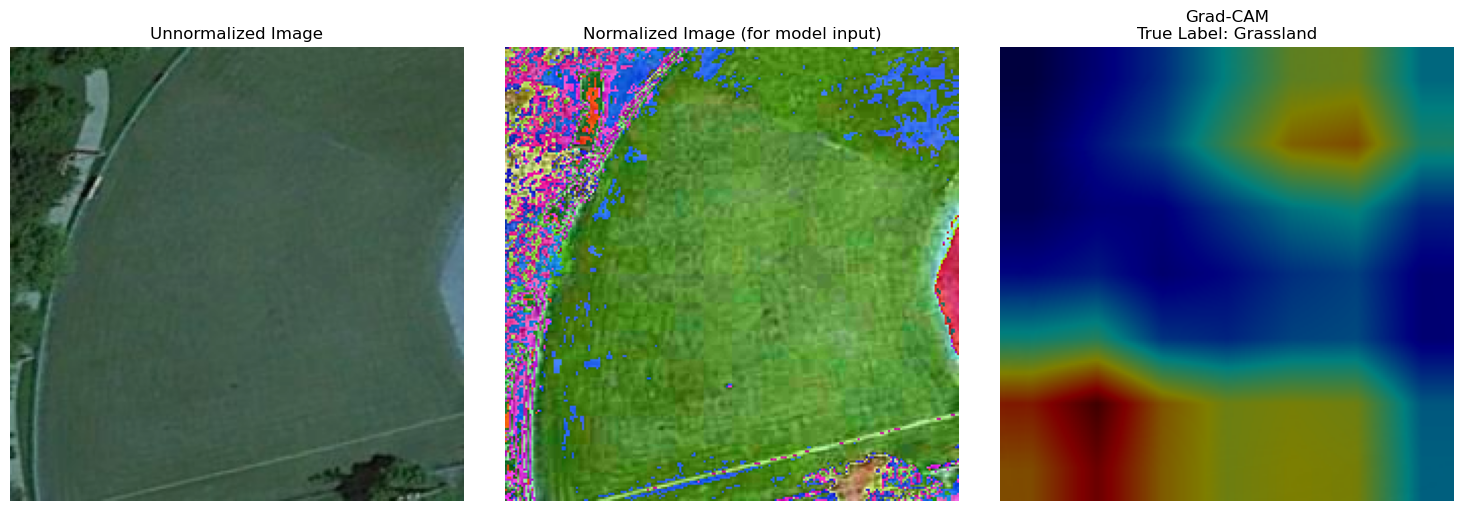

In [ ]:

# ✅ Grad-CAM 应用：可视化模型注意区域

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = initialize_model(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("best_resnet_model.pth", map_location=device))
model.eval()

# 选择 ResNet18 的最后一个卷积层
target_layer = model.layer4[-1].conv2
gradcam = GradCAM(model, target_layer)

# 随机选一张测试图片
import random
idx = random.randint(0, len(test_dataset) - 1)
raw_image, label = test_dataset[idx]
input_tensor = raw_image.unsqueeze(0).to(device)

# 生成热力图
cam = gradcam(input_tensor)
raw_image_np = raw_image.permute(1, 2, 0).cpu().numpy()
result = overlay_heatmap(raw_image_np, cam)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# 反标准化（mean 和 std 与训练时一致）
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnorm_image = raw_image_np * std + mean
unnorm_image = np.clip(unnorm_image, 0, 1)

# 原图（标准化图像展示，仅作为参考，会偏色）
standard_rgb = cv2.cvtColor((raw_image_np * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)

# 反标准化图像（恢复正常色调）
unnorm_rgb = cv2.cvtColor((unnorm_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)

# 可视化：3 张图并排显示
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(unnorm_rgb)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(standard_rgb)
axs[1].set_title("Normalized Image (for model input)")
axs[1].axis("off")

axs[2].imshow(result)
axs[2].set_title(f"Grad-CAM\nTrue Label: {class_names[label]}")
axs[2].axis("off")

plt.tight_layout()
plt.show()



C:\Users\YANJUN\AppData\Local\Temp\ipykernel_43144\2560733038.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet_model.pth", 

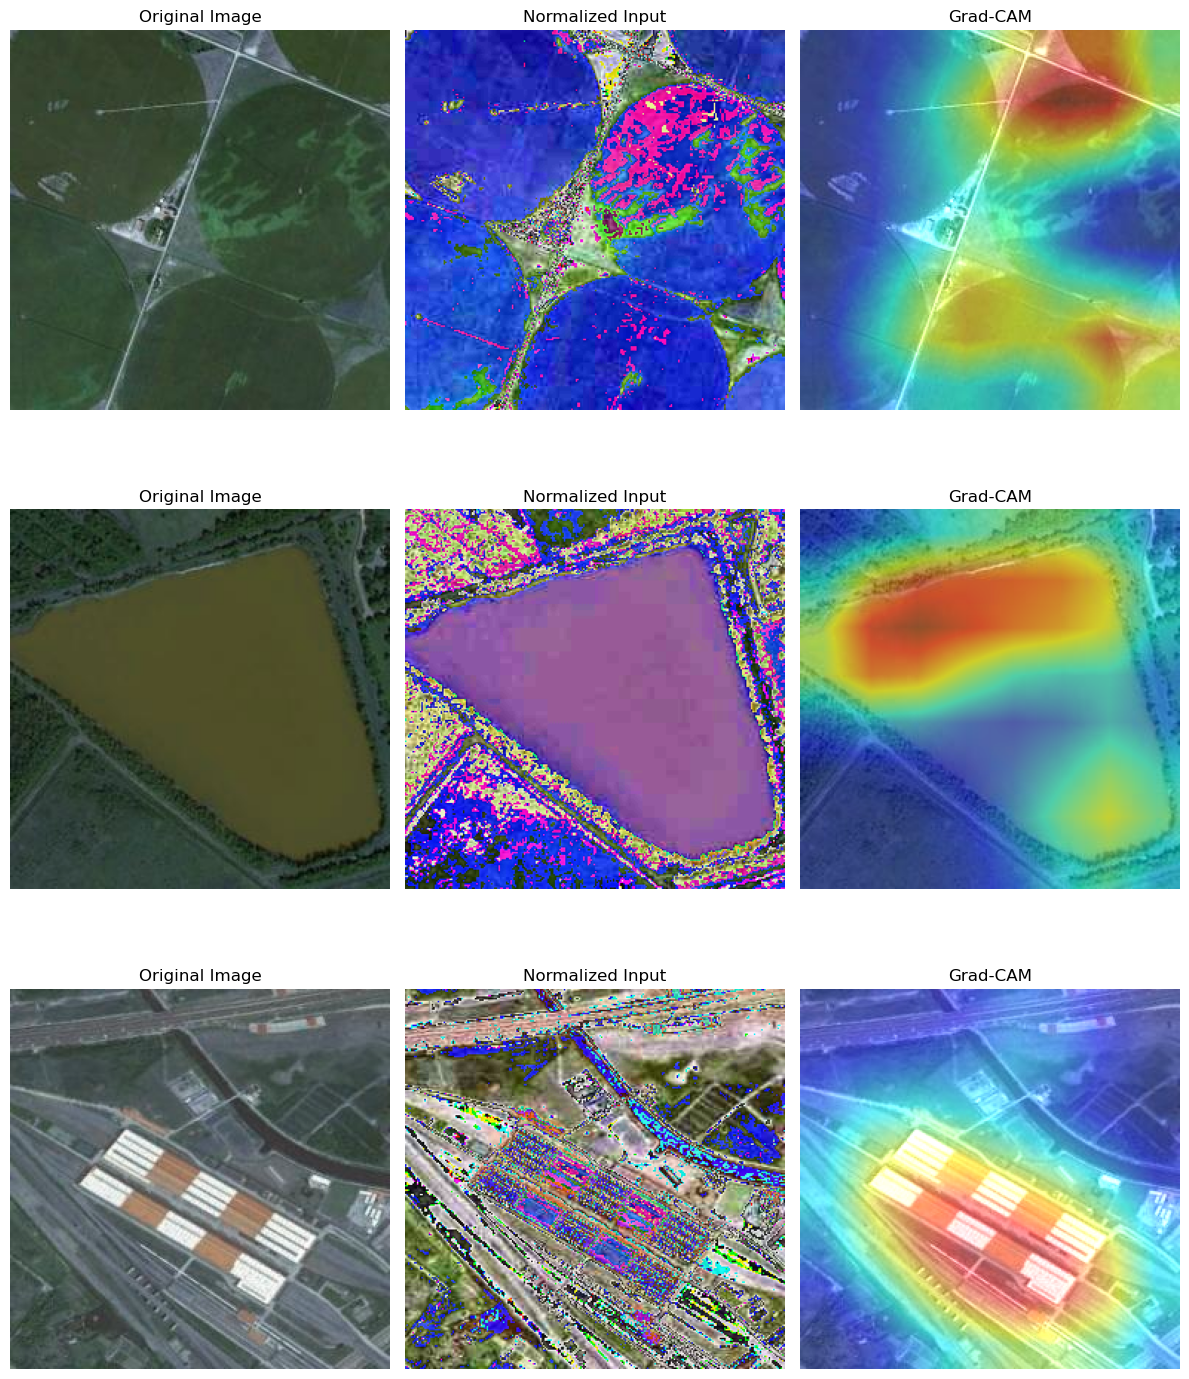

In [10]:
# ✅ 支持自定义路径输入的 Grad-CAM 可视化

# 指定测试图像路径列表（最多三组）
image_paths = [
    "../split_data/test/Agriculture/111.jpg",
    "../split_data/test/Lake/533.jpg",
    "../split_data/test/Railway/193.jpg"
]

# 加载模型与 GradCAM 设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = initialize_model(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("best_resnet_model.pth", map_location=device))
model.eval()
target_layer = model.layer4[-1].conv2
gradcam = GradCAM(model, target_layer)

# transforms：与训练一致
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 画图
fig, axs = plt.subplots(len(image_paths), 3, figsize=(12, 5 * len(image_paths)))

for i, path in enumerate(image_paths):
    # 加载图片并转换
    img_bgr = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)

    # Grad-CAM
    cam = gradcam(img_tensor)
    cam_overlay = overlay_heatmap(img_rgb, cam)
    cam_overlay = cv2.cvtColor(cam_overlay, cv2.COLOR_BGR2RGB)

    # 标准化图像（输入给模型的）
    norm_rgb = cv2.cvtColor((img_tensor.squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)

    # 反标准化图像
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnorm_image = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    unnorm_image = unnorm_image * std + mean
    unnorm_image = np.clip(unnorm_image, 0, 1)
    unnorm_rgb = cv2.cvtColor((unnorm_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)

    # 绘制三张图
    axs[i, 0].imshow(unnorm_rgb)
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(norm_rgb)
    axs[i, 1].set_title("Normalized Input")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(cam_overlay)
    axs[i, 2].set_title("Grad-CAM")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()
